# ARIMA (p, d, q)
### AR (Auto - Regressive): TS is linearly regressed on its own past values

p: number of past values included in the AR model

### I (Intergrated): TS can be differenced to become stationary if not

d: the number of times the time series is differenced

### MA (Moving Average): TS is regressed on the past forecast errors

q: the number of past forecast errors included in the MA model

In [1]:
# import modules
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt

  
# initialize parameters
start_date = datetime(2019, 1, 1)
end_date = datetime(2023, 6, 1)
  
# get the datab
df = yf.download('AAPL', start = start_date,
                   end = end_date)
df.reset_index(drop = True, inplace = True)
df = df[['Adj Close']]

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:>

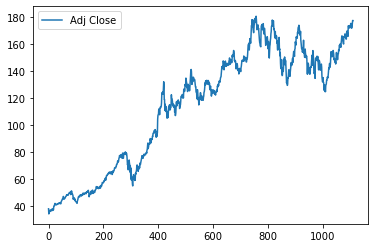

In [2]:
df.plot()

<AxesSubplot:>

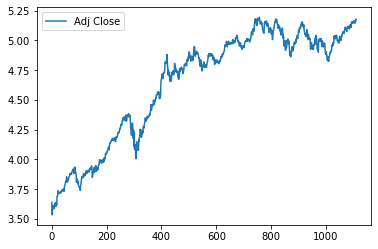

In [3]:
import numpy as np

df = np.log(df) # dont forget to transform data back for real prediction
df.plot()

In [4]:
size = round(len(df)*0.8)
df_train = df[:size].copy()
df_test = df[size:].copy()

# ACF and PACF plot

### ACF (autocorrelation function) : correlation of the TS with its lags

### PACF (partical autocorrelation function) : partial correlation of the TS with lags after removing the effects of lower order lags between them

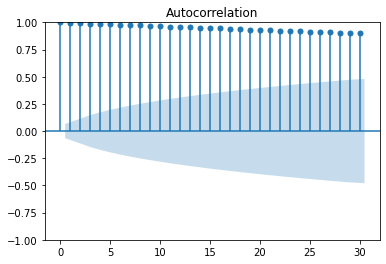

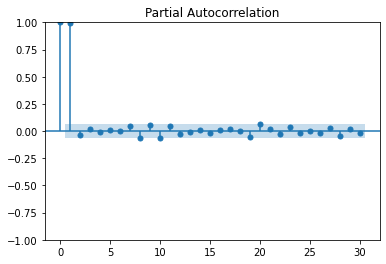

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_original = plot_acf(df_train)
pacf_original = plot_pacf(df_train)

# ADF test

In [6]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}') # p > 0.05, non-stationary

p-value: 0.29073873649532056


# Transform to stationary: differencing

<AxesSubplot:>

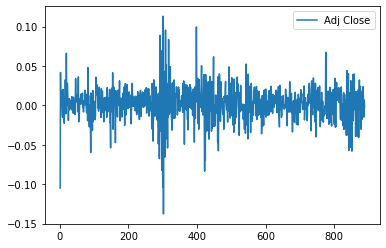

In [7]:
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

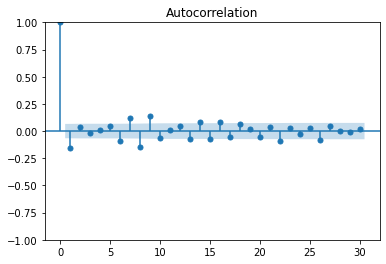

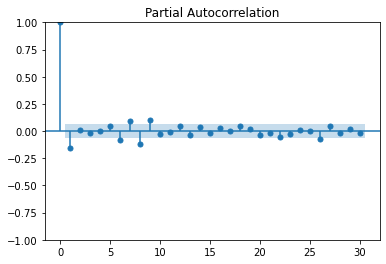

In [8]:
acf_diff = plot_acf(df_train_diff) # determine q
pacf_diff = plot_pacf(df_train_diff) # determine p

In [9]:
adf_test_diff = adfuller(df_train_diff)
print(f'p-value: {adf_test_diff[1]}')

p-value: 3.3519726288607425e-16


In [10]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order = (1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  889
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2152.242
Date:                Mon, 05 Jun 2023   AIC                          -4298.483
Time:                        22:35:45   BIC                          -4284.116
Sample:                             0   HQIC                         -4292.991
                                - 889                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2960      0.129     -2.299      0.022      -0.548      -0.044
ma.L1          0.1460      0.136      1.072      0.284      -0.121       0.413
sigma2         0.0005   1.28e-05     35.848      0.0

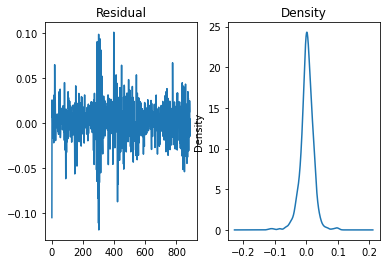

In [11]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title = 'Residual', ax = ax[0])
residuals.plot(title = 'Density', kind = 'kde', ax = ax[1])
plt.show()

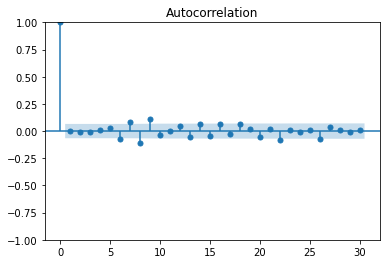

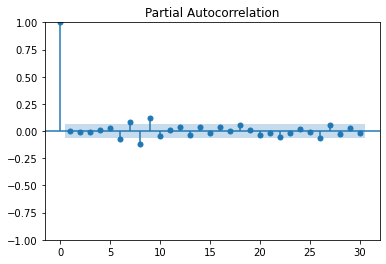

In [12]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals) #close to white noise

<AxesSubplot:>

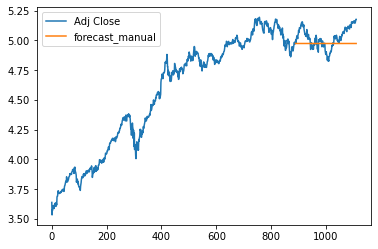

In [13]:
forecast_test = model_fit.forecast(len(df_test))
df['forecast_manual'] = [None]* len(df_train) + list(forecast_test)
df.plot()

In [14]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train,stepwise = False, seasonal = False)
auto_arima

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

In [15]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  889
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2155.054
Date:                Mon, 05 Jun 2023   AIC                          -4304.107
Time:                        22:35:56   BIC                          -4289.741
Sample:                             0   HQIC                         -4298.616
                                - 889                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0018      0.001      2.416      0.016       0.000       0.003
ar.L1         -0.1594      0.021     -7.508      0.000      -0.201      -0.118
sigma2         0.0005   1.26e-05     36.158      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               808.51
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.40
Prob(H) (two-sided):                  1.00   Kurtosis:                         7.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

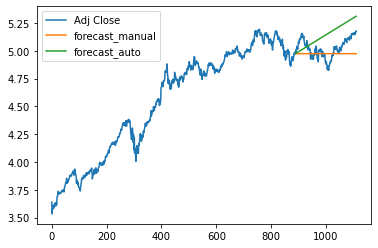

In [16]:
forecast_test_auto = auto_arima.predict(n_periods = len(df_test))
df['forecast_auto'] = [None]* len(df_train) + list(forecast_test_auto)
df.plot()

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(df_test,forecast_test)
rmse = mean_squared_error(df_test,forecast_test)

print('mae:' + str(mae)) #lower means better
print('mae:' + str(rmse))

mae:0.07847147533613946
mae:0.009208257339221568


In [18]:
mae = mean_absolute_error(df_test,forecast_test_auto)
rmse = mean_squared_error(df_test,forecast_test_auto)

print('mae:' + str(mae))
print('mae:' + str(rmse))

mae:0.14604843861764416
mae:0.026655756323682188
